# Part A. The Quantum Teleportation Protocol 

In [1]:
#Import qiskit
from qiskit import *


## Example 1.

$q_{0}$ is a $|0>$ state

$q_{1}$ is a $|0>$ state

$q_{2}$ is a $|0>$ state

In [2]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")      # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)


### Step 1. 

Bob and Alice shared an entangled pair of qubits.
The pair is called a Bell pair. 

Process for creating a Bell pair between two qubits:
1. transfer one of them to the X-basis (|+⟩ and |−⟩) using a Hadamard gate. 
2. And then apply a CNOT gate onto the other qubit(q2) controlled by q1 in the X-basis.
Note: If q1 = 1, then q2 will flip otherwise q2 will not change.


In [3]:
def create_bell_pair(qc, q1, q2):
    """Creates a bell pair in qc using qubits q1 & q2"""
    qc.h(q1)     # Put qubit q1 into state |+> : a superposition state |0> and |1>
    qc.cx(q1,q2) # CNOT with q1 as control and q2 as target 
    

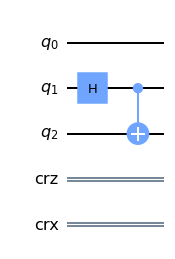

In [4]:
## STEP 1
#  qubit q1 and qubit q2 are entangled

# Let's apply the process above to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)

# View the circuit so far:
%matplotlib inline
teleportation_circuit.draw(output='mpl')


### Step 2. 

Alice applies a CNOT gate to |q1>, controlled by |ψ⟩(the qubit she is trying to send Bob). 
Then Alice applies a Hadamard gate to |ψ⟩. 
In our quantum circuit, the qubit (|ψ⟩) Alice is trying to send is |q0>:


In [5]:
# Define a function to Transform the Bell states into 
# states |00>, |01>, |10>, and |11> by applying a CNOT gate 
# and a Hadamard gate on |q0, q1, q2>
def alice_gates(qc, q0, q1):
    qc.cx(q0, q1)
    qc.h(q0)
    

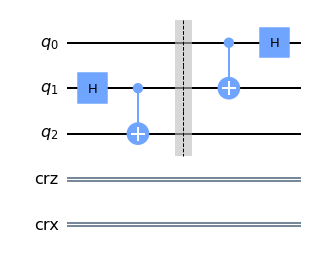

In [6]:
## STEP 2
teleportation_circuit.barrier() # Use barrier to separate the steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')


### Step 3. 

Next, Alice applies a measurement to both qubits that she owns,  
q1 and |ψ⟩, and stores this result in two classical bits. She then sends these two bits to Bob.


In [7]:
def measure_and_send(qc, q0, q1):
    """Measures qubits q0 & q1 and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(q0,0)
    qc.measure(q1,1)
    

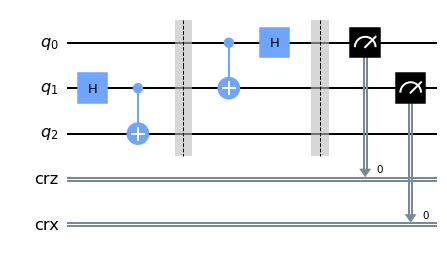

In [8]:
## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw(output='mpl')


### Step 4. 

Bob, who already has the qubit q2, then applies the following gates depending on the state of the classical bits:

00  → Do nothing

01  → Apply X gate

10  → Apply Z gate

11  → Apply ZX gate



In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
    

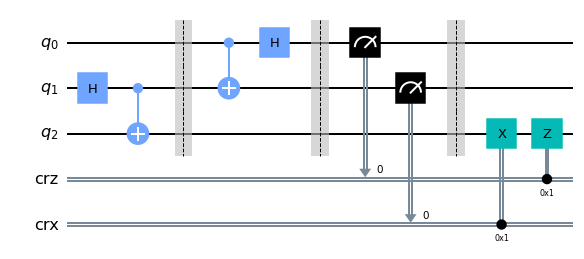

In [10]:
## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw(output='mpl')


# Part B. Simulating the Teleportation Protocol Using a Random State

### Step 1. 
Initialize Alice's qubit in a random state |ψ⟩(psi).
This state will be created using an Initialize gate on |q0⟩. 

In [11]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex


<IPython.core.display.Math object>

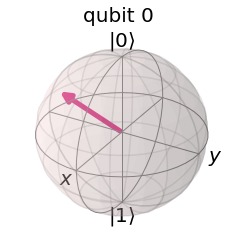

In [12]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")

# Show it on a Bloch sphere
plot_bloch_multivector(psi)


In [13]:
# initialization instruction to create  
# |ψ⟩ from the state |0⟩:
#(Initialize is technically not a gate since it contains a reset operation.)
init_gate = Initialize(psi)
init_gate.label = "init"


### Step2. 
Use the statevector simulator to verify our qubit has been teleported.

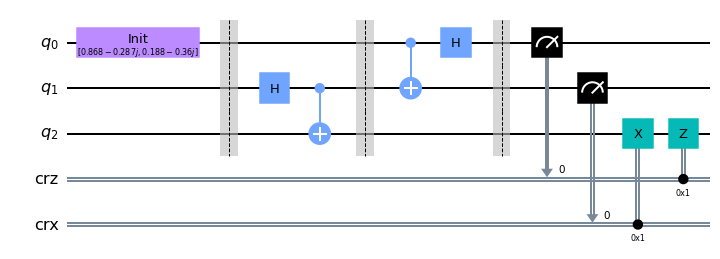

In [14]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw(output='mpl')


### Step3. Plot the results using the statevector_simulator(shown on Bloch spheres)
We can see below, using our statevector simulator, that the state of  |q2⟩ is the same as the state  
|ψ⟩ we created above, while the states of |q0⟩ and |q1⟩ have been collapsed to either |0⟩ or |1⟩. 
The state |ψ⟩ has been teleported from qubit 0 to qubit 2.

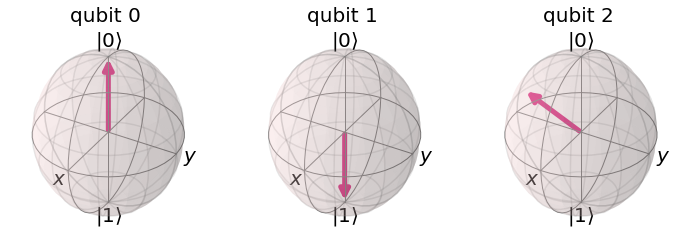

In [15]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)


### Step3. 
Use the QASM simulator to verify our qubit has been teleported.
Quantum teleportation is designed to send qubits between two parties. 
We do not have the hardware to demonstrate this, but we can demonstrate 
that the gates perform the correct transformations on a single quantum chip. 
Here we use the QASM simulator to simulate how we might test our protocol.
On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. The Initialize instruction first performs a reset, setting our qubit to the state  |0⟩. It then applies gates to turn our |0⟩ qubit into the state  |ψ⟩:

In [16]:
#Since all quantum gates are reversible, 
#we can find the inverse of these gates using:
inverse_init_gate = init_gate.gates_to_uncompute()

To prove the qubit  |q0⟩ has been teleported to |q2⟩, 
if we do this inverse initialization on |q2⟩, we expect to measure|0⟩ with certainty. 
We do this in the circuit below:

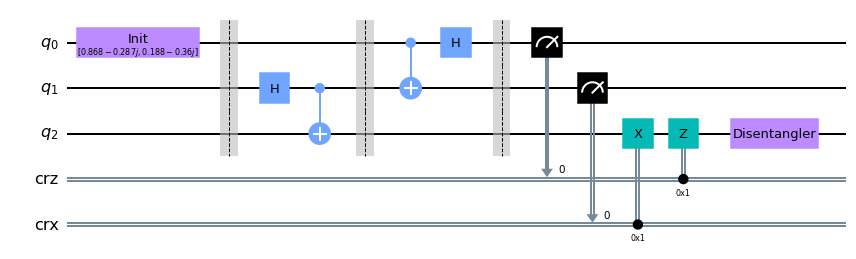

In [17]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw(output='mpl')


We can see the inverse_init_gate appearing, labelled 'disentangler' on the circuit diagram. 

Finally, we measure the qubit |q2> and store the result in the third classical bit:

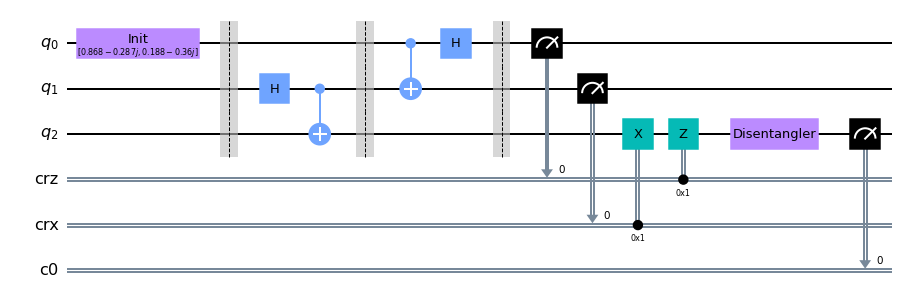

In [18]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw(output='mpl')


### Step4. Plot the results using the QASM_simulator(shown on histogram)

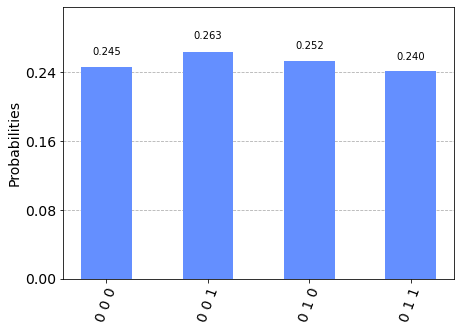

In [19]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts() # No. of measurement shots = 1024
plot_histogram(counts)


We can see we have a 100% chance of measuring q2(the leftmost bit in the string) in the state |0⟩. 

This is the expected result, and indicates the teleportation protocol has worked properly.

